In [1]:
%matplotlib widget
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from species_transport import set_BCs, set_Temp_BC, evolve_species
from visualization import plot_velocity_vector_field
import time
from Funcs import metric_L0, metric_RMS

In [7]:
N, M = 200,200
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
dt = dt_fluid_flow(dx, Fo=0.3)

In [8]:
# load the velocity field:
datap = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
u,v,_ = np.load(datap)
#plot_velocity_vector_field(u,v)

In [9]:
# initial setup of the species distribution
CH4, O2, N2, H2O, CO2, T = np.zeros((6,N,M))
O2[:] = .233
N2[:] = .767
T[:] = 300
Y = np.array([CH4, O2, N2, CO2, H2O])

# initial iterations before staerting the analysis
#Nt0 = int(500 * 3.2e-5 / dt)
Nt0 = 1

# number of iterations between 2 convergence measurements
Nt = 10

# number of convergence measurements
N_loop = int(150 * 3.2e-5 / dt)

# placeholders for the respective metrics (here we evolve 3 species only)
L0 = np.zeros((3,N_loop))
L2 = np.zeros_like(L0)

# initial warm-up:
Y, T = evolve_species(Nt0, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=False, evolve_T=False)

t0 = time.time()
# convergence analysis:
for i in range(N_loop):
    
    t = i * dt * Nt + dt * Nt0 # current phyiscal time in [s]
    
    Y_old = np.copy(Y)
    Y, T = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=False, evolve_T=False)
    
    # measurements:
    for k in range(L0.shape[0]):
        L0[k,i] = metric_L0(Y_old[k], Y[k])
        L2[k,i] = metric_RMS(Y_old[k], Y[k])
print('CPU time [s]: ', time.time() - t0)

CPU time [s]:  245.86555695533752


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
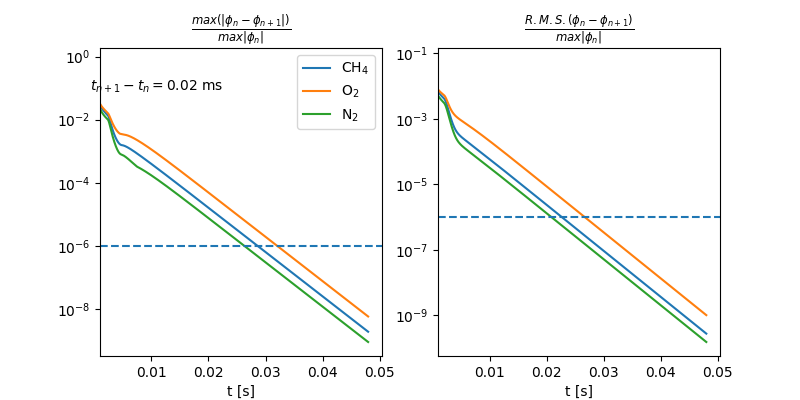

In [10]:
t = np.arange(N_loop) * dt * Nt + dt * Nt0

fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4), sharex=True)
from species_transport import species_names

for i in range(L0.shape[0]):
    ax.plot(t, L0[i], label=species_names[i])
    ax2.plot(t, L2[i], label=species_names[i])

ax.set_xlabel('t [s]')
ax2.set_xlabel('t [s]')
if True:
    ax.set_yscale('log')
    ax2.set_yscale('log')
    #ax.set_xscale('log')
    #ax2.set_xscale('log')

ax.set_title(r'$\frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
ax2.set_title(r'$\frac{ R.M.S.( \phi_n - \phi_{n+1} ) }{ max |\phi_n| }$')

s = r'$t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(Nt * dt * 1e3)
ax.text(0.2, 0.9, s, verticalalignment='top', horizontalalignment='center', transform=ax.transAxes)
for a in [ax, ax2]:
    a.axhline(1e-6, ls='--')
    a.set_xlim(left=1e-3)
    #a.plot(T, get_atol(T, amin, amax, tmax), label='atol')
ax.legend()

We see that we are easily below the 10$^{-6}$ threshold if we take the stationarity time to be $t=0.04\,s$

In [12]:
from species_transport import compute_Y_pre_combustion, save_Y_T, load_Y_T

In [13]:
N_list = np.array([30,50,70,100,130, 160, 200,250])
#N_list = np.array([30,50])

In [25]:
import time

Chrono = np.zeros(N_list.size)

for i, N in enumerate(N_list):
    load_p = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
    u,v,_ = np.load(load_p)
    
    t0 = time.time()
    Y,T = compute_Y_pre_combustion(N, u,v, t=0.04)
    Chrono[i] = time.time() - t0
    
    save_p = Path('data/species/test0') / 'N{}.npy'.format(N)
    save_Y_T(Y,T,save_p)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
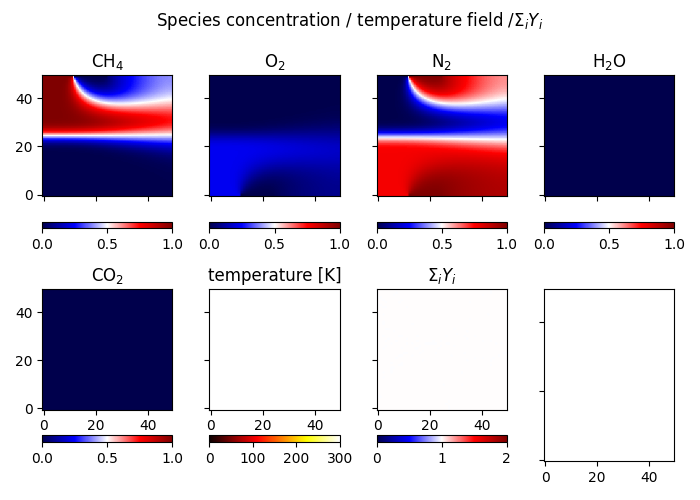

In [ ]:
Y,T = load_Y_T(save_p)
#fig, axs = plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
#plot_species_overview(Y,T, axs=axs)